Book Rating Prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip uninstall -y numpy gensim thinc

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3


In [3]:
!which python
!which pip
!python --version
!pip --version

/usr/local/bin/python
/usr/local/bin/pip
Python 3.11.12
pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)


In [8]:
!pip install contractions
!pip install wordcloud gensim
from wordcloud import WordCloud
import gensim.downloader as api

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, which is not installed.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

In [10]:
from wordcloud import WordCloud
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

Load The Dataset

In [11]:
df = pd.read_csv('/content/drive/MyDrive/3 year/6 semester/Artificial Intelligence & Machine Learning/Coursework-2/Book Review Dataset/Book_review.csv')
df.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


Clean The Text

In [12]:
df.tail()

,Unnamed: 0,rating,reviewText,summary
11995,11995,2,Had to read certain passages twice--typos. Wi...,Where's the meat?
11996,11996,3,Not what i expected. yet a very interesting bo...,Interesting
11997,11997,5,Dragon Knights is a world where Knights ride d...,"Dragon Knights, Wings of Change (I Dream of Dr..."
11998,11998,4,"Since this story is very short, it's hard to s...","Good writing, short story"
11999,11999,4,from 1922 an amazing collection of info on sym...,interesting public domain book


In [13]:
df.shape

(12000, 4)

In [14]:
df.columns

Index(['Unnamed: 0', 'rating', 'reviewText', 'summary'], dtype='object')

In [15]:
df = df.drop(columns=['Unnamed: 0'])

In [16]:
df.head()

,rating,reviewText,summary
0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [17]:
df['rating'].unique()

array([5, 1, 4, 3, 2])

In [18]:
df['reviewText'].duplicated()

,reviewText
0,False
1,False
2,False
3,False
4,False
...,...
11995,False
11996,False
11997,False
11998,False


<ipython-input-19-6a451fd58f5a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rating', palette='viridis')


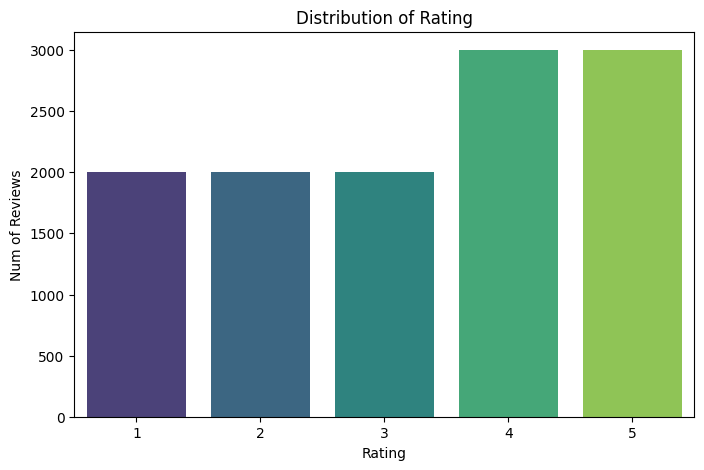

In [19]:
# Vizualizing the distribution of data
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title("Distribution of Rating")
plt.xlabel("Rating")
plt.ylabel("Num of Reviews")
plt.show()

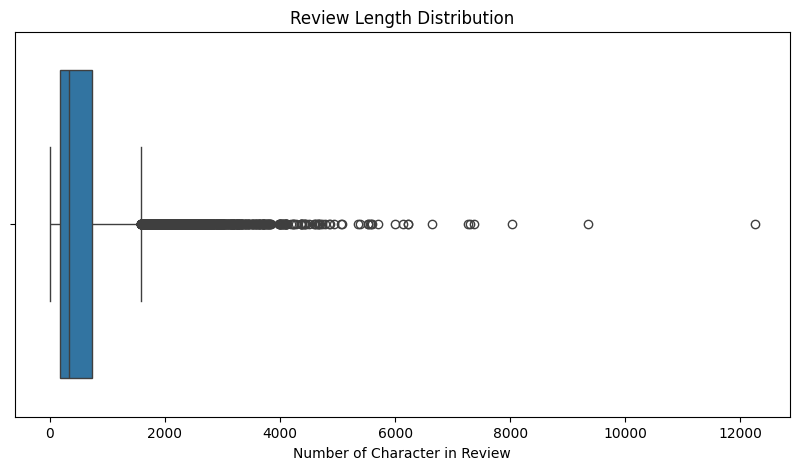

In [20]:
# Visualizing Review Length
df['reviewLength'] = df['reviewText'].astype(str).apply(len)

plt.figure(figsize=(10, 5))
plt.title("Review Length Distribution")
plt.xlabel("Number of Character in Review")
sns.boxplot(x=df['reviewLength'])
plt.show()

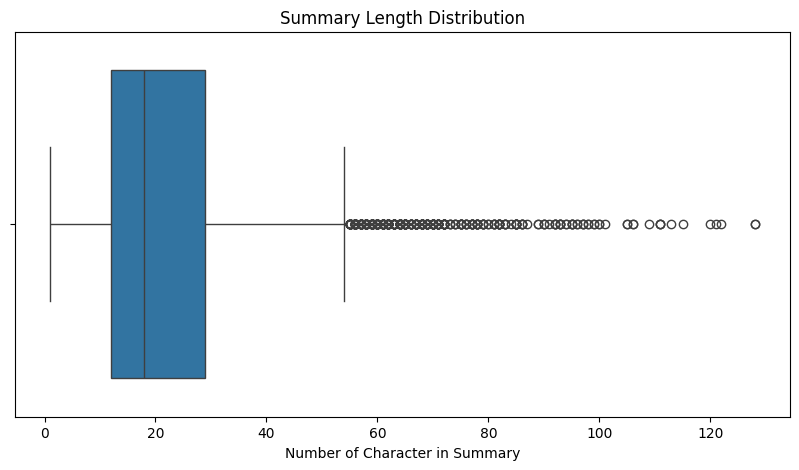

In [21]:
# Visualizing Summaray Length
df['summaryLength'] = df['summary'].astype(str).apply(len)

plt.figure(figsize=(10, 5))
plt.title("Summary Length Distribution")
plt.xlabel("Number of Character in Summary")
sns.boxplot(x=df['summaryLength'])
plt.show()

In [22]:
df.isnull().sum()

,0
rating,0
reviewText,0
summary,2
reviewLength,0
summaryLength,0


In [23]:
df['summary'] =df['summary'].fillna("No Summary Provided")

In [24]:
df.isnull().sum()

,0
rating,0
reviewText,0
summary,0
reviewLength,0
summaryLength,0


In [25]:
df.describe()

,rating,reviewLength,summaryLength
count,12000.000000,12000.000000,12000.000000
mean,3.250000,601.562750,22.225833
std,1.421619,710.158377,14.958910
min,1.000000,7.000000,1.000000
25%,2.000000,170.750000,12.000000
50%,3.500000,332.000000,18.000000
75%,4.250000,737.000000,29.000000
max,5.000000,12246.000000,128.000000


In [26]:
# Upsampling the minority Classes
df1 = df[df['rating'] == 1]
df2 = df[df['rating'] == 2]
df3 = df[df['rating'] == 3]
df4 = df[df['rating'] == 4]
df5 = df[df['rating'] == 5]

df1US = resample(df1, replace=True, n_samples=3000, random_state=42)
df2US = resample(df2, replace=True, n_samples=3000, random_state=42)
df3US = resample(df3, replace=True, n_samples=3000, random_state=42)

dfBalanced = pd.concat([df1US,df2US,df3US,df4,df5])

dfBalanced = dfBalanced.sample(frac=1, random_state=42).reset_index(drop=True)

<ipython-input-27-69b451c3b407>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dfBalanced, x='rating', palette='viridis')


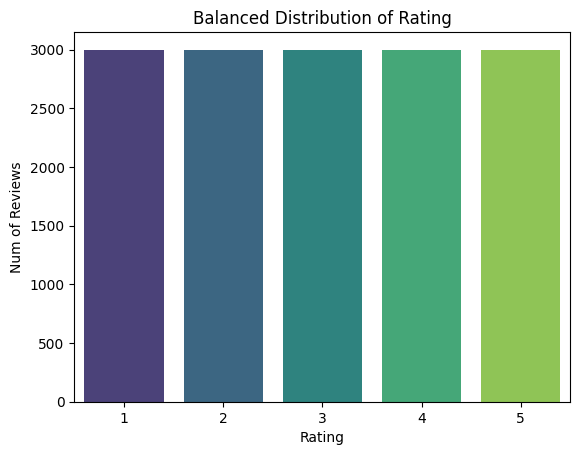

In [27]:
sns.countplot(data=dfBalanced, x='rating', palette='viridis')
plt.title("Balanced Distribution of Rating")
plt.xlabel("Rating")
plt.ylabel("Num of Reviews")
plt.show()

In [28]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [29]:
stopWords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [30]:
def cleanReview(text):
    if pd.isnull(text):
        return ""

    text = text.lower()
    text = contractions.fix(text)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+|\d+", '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)

    words = nltk.word_tokenize(text)

    words = [lemmatizer.lemmatize(word) for word in words if word not in stopWords]

    return " ".join(words)

df['cleanedReviewText'] = df['reviewText'].apply(cleanReview)

Visualize the cleaned data

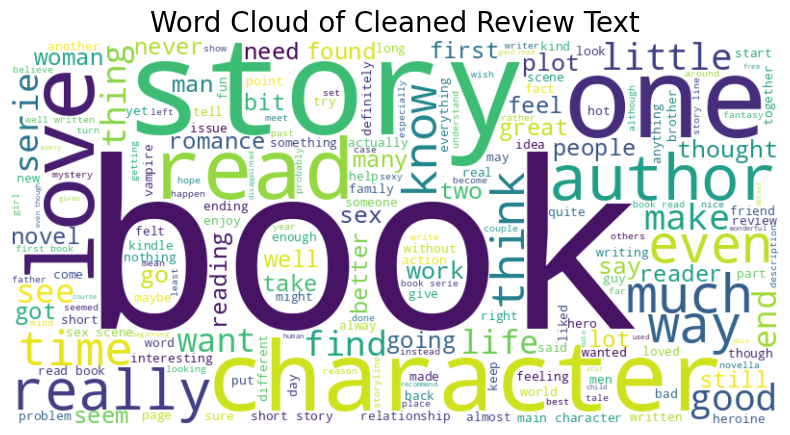

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(review for review in df['cleanedReviewText'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Review Text', fontsize=20)
plt.show()

In [32]:
from collections import Counter

allWords = " ".join(df['cleanedReviewText']).split()
wordFreq = Counter(allWords)

commonWords = wordFreq.most_common(20)
words, counts = zip(*commonWords)

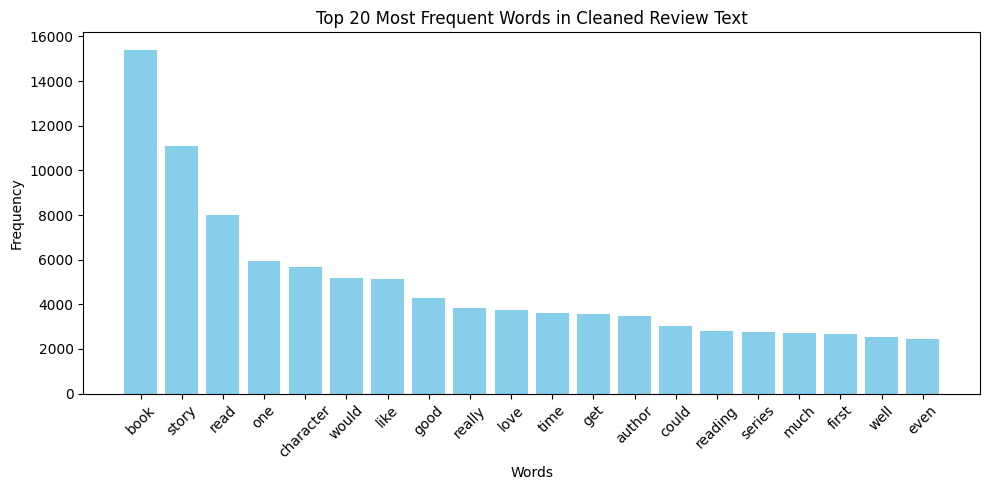

In [33]:
plt.figure(figsize=(10,5))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words in Cleaned Review Text")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Tokenization and Padding

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SimpleRNN

In [35]:
X = df['cleanedReviewText']
y = df['rating'].values - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Tokenization and Padding with Percentile-Based Length
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [37]:
# Calculate 95th percentile for max_len
sequence_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(sequence_lengths, 95))
print(f"Setting max_len to {max_len}")

Setting max_len to 165


In [38]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [39]:
# Convert labels to categorical
num_classes = 5
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [40]:
# Define Early Stopping
#patience = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [41]:
# Model 1: Simple RNN with Trainable Embedding Layer (with regularization)
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_rnn.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(Dense(num_classes, activation='softmax'))
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [42]:
# Train Model 1
history_rnn = model_rnn.fit(X_train_pad, y_train_cat, batch_size=64, epochs=15, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test_cat)
print(f"Test accuracy: {accuracy*100:.2f}%")

Epoch 1/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.2209 - loss: 1.6610 - val_accuracy: 0.2583 - val_loss: 1.5925
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.2640 - loss: 1.6015 - val_accuracy: 0.2844 - val_loss: 1.5785
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.2993 - loss: 1.5466 - val_accuracy: 0.2865 - val_loss: 1.5629
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.3510 - loss: 1.4949 - val_accuracy: 0.2896 - val_loss: 1.5401
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 159ms/step - accuracy: 0.4358 - loss: 1.4012 - val_accuracy: 0.3135 - val_loss: 1.5287
Epoch 6/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 37s 127ms/step - accuracy: 0.5015 - loss: 1.2839 - val_accuracy: 0.3260 - val_loss: 1.5279
Epoch 7/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.5113 - loss: 1.2542 - val_accuracy: 0.3177 - val_loss: 1.5434
Epoch 8/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.5634 - loss: 1

In [43]:
# Model 2: LSTM with Trainable Embedding Layer
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model 2
history_lstm = model_lstm.fit(X_train_pad, y_train_cat, batch_size=64, epochs=15, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 90s 638ms/step - accuracy: 0.2913 - loss: 1.5167 - val_accuracy: 0.3927 - val_loss: 1.3079
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 137s 601ms/step - accuracy: 0.4923 - loss: 1.1298 - val_accuracy: 0.4573 - val_loss: 1.2571
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 86s 641ms/step - accuracy: 0.6321 - loss: 0.9001 - val_accuracy: 0.4437 - val_loss: 1.3001
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 144s 659ms/step - accuracy: 0.7168 - loss: 0.7225 - val_accuracy: 0.4385 - val_loss: 1.4233
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 133s 592ms/step - accuracy: 0.7769 - loss: 0.5927 - val_accuracy: 0.4396 - val_loss: 1.5369


In [44]:
import numpy
print(numpy.__version__)  # Should print 1.26.4
import gensim.downloader as api
print("Gensim imported successfully!")

1.26.4
Gensim imported successfully!


In [46]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00


In [47]:
import gradio as gr

In [48]:
# Model 3: LSTM with Pretrained Word2Vec Embeddings (using GloVe for efficiency)
word2vec = api.load('glove-wiki-gigaword-50')  # 50-dimensional GloVe embeddings
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]

model_lstm_w2v = Sequential()
model_lstm_w2v.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_lstm_w2v.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_lstm_w2v.add(Dense(num_classes, activation='softmax'))
model_lstm_w2v.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model 3
history_lstm_w2v = model_lstm_w2v.fit(X_train_pad, y_train_cat, batch_size=64, epochs=15, validation_split=0.1, callbacks=[early_stopping])

[==================================================] 100.0% 66.0/66.0MB downloaded
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


135/135 ━━━━━━━━━━━━━━━━━━━━ 72s 504ms/step - accuracy: 0.2805 - loss: 1.5625 - val_accuracy: 0.3125 - val_loss: 1.4694
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 70s 516ms/step - accuracy: 0.3446 - loss: 1.4582 - val_accuracy: 0.3917 - val_loss: 1.4076
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 63s 468ms/step - accuracy: 0.3816 - loss: 1.4277 - val_accuracy: 0.4083 - val_loss: 1.3788
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 80s 454ms/step - accuracy: 0.3881 - loss: 1.3850 - val_accuracy: 0.4156 - val_loss: 1.3537
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 61s 451ms/step - accuracy: 0.4023 - loss: 1.3716 - val_accuracy: 0.4271 - val_loss: 1.3319
Epoch 6/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 63s 470ms/step - accuracy: 0.4183 - loss: 1.3397 - val_accuracy: 0.4271 - val_loss: 1.3299
Epoch 7/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 60s 446ms/step - accuracy: 0.4268 - loss: 1.3194 - val_accuracy: 0.4385 - val_loss: 1.3152
Epoch 8/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 60s 448ms/step - accuracy: 0.4308 - loss: 1.3008 - val

In [49]:
# Evaluation Function
def evaluate_model(model, X_test_pad, y_test_cat, y_test, name):
    loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
    print(f"{name} Test accuracy: {accuracy*100:.2f}%")

    y_pred = model.predict(X_test_pad)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)
    print(f"{name} Confusion Matrix:")
    print(cm)

    report = classification_report(y_test, y_pred_classes)
    print(f"{name} Classification Report:")
    print(report)

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3155 - loss: 1.5324
Simple RNN Test accuracy: 30.83%
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Simple RNN Confusion Matrix:
[[100  55  22 122 106]
 [ 51  84  36 109 114]
 [ 34  57  32 140 149]
 [ 36  61  42 223 225]
 [ 23  46  30 202 301]]
Simple RNN Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.25      0.31       405
           1       0.28      0.21      0.24       394
           2       0.20      0.08      0.11       412
           3       0.28      0.38      0.32       587
           4       0.34      0.50      0.40       602

    accuracy                           0.31      2400
   macro avg       0.30      0.28      0.28      2400
weighted avg       0.30      0.31      0.29      2400

75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.4892 - loss: 1.2031
LSTM Test accuracy: 49.00%
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step
LSTM Confusion Matrix:
[[291  42  16  30  26

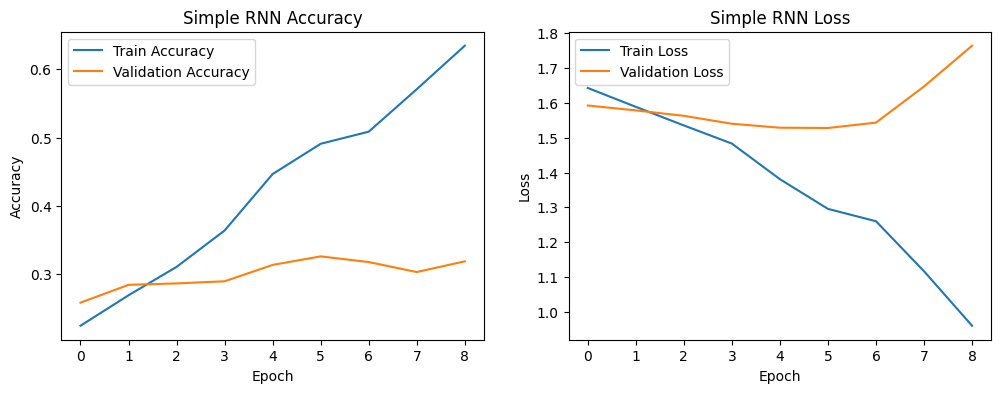

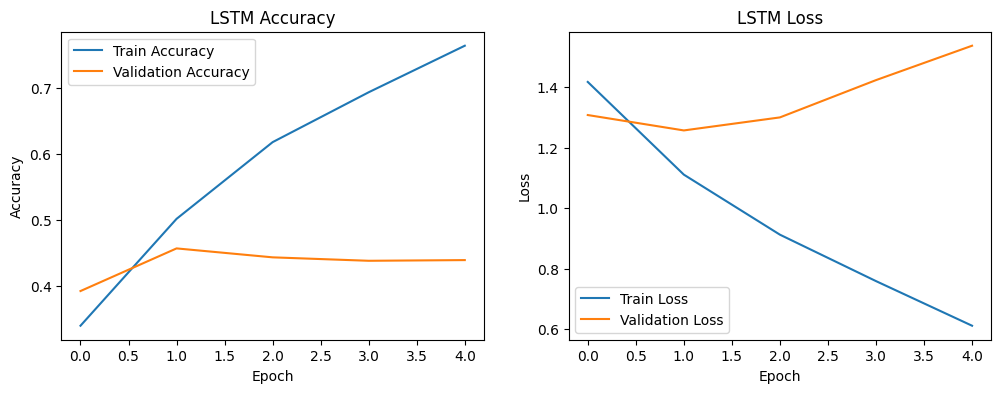

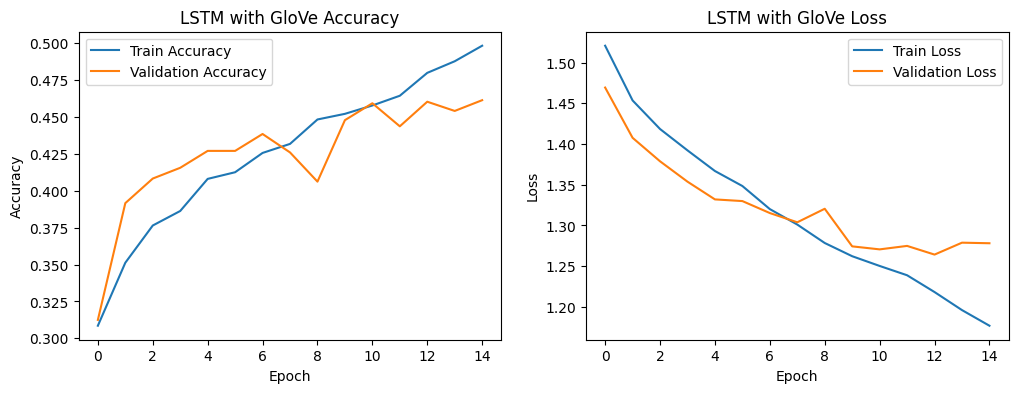

In [50]:
# Evaluate all models
evaluate_model(model_rnn, X_test_pad, y_test_cat, y_test, "Simple RNN")
evaluate_model(model_lstm, X_test_pad, y_test_cat, y_test, "LSTM")
evaluate_model(model_lstm_w2v, X_test_pad, y_test_cat, y_test, "LSTM with GloVe")

# Visualization Function
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Plot histories
plot_history(history_rnn, 'Simple RNN')
plot_history(history_lstm, 'LSTM')
plot_history(history_lstm_w2v, 'LSTM with GloVe')

In [51]:
# GUI for Real-Time Prediction using Gradio
def predict_sentiment(text, model):
    cleaned_text = cleanReview(text)
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    sentiment = np.argmax(pred, axis=1)[0] + 1  # Adjust back to 1-5 scale
    return f"Predicted rating: {sentiment}"

# Use the LSTM model for the GUI (you can change to model_rnn or model_lstm_w2v)
interface = gr.Interface(fn=lambda text: predict_sentiment(text, model_lstm), inputs="text", outputs="text", title="Book Review Rating Prediction")
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dfc82c2654a3653d12.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
